# Analysis of single cell RNA sequencing data using Seurat

This is the iphyton data used for the single cell RNA sequencing class as a part of the 'Bioinformatics in Neuroscience' course, part of the Neuroscience and Cognition master program. The script follows the well known vignette of the Seurat pipeline for pbmc, adapted to analyse the 20k sample of the scRNAseq of 1.3M cells of the E18 embryonic brain provided by 10x. The data can be downloaded from the 10x website (may need free registration to reach the full and 20k sample) here: https://support.10xgenomics.com/single-cell-gene-expression/datasets

The course used the CoCalc server: https://cocalc.science.uu.nl/

This pipeline is designed to process a count matrix where each column represents a cell and each row represents a 'feature', which could be a gene as well as a micro RNA or non-coding RNA. The values show the expression level of a gene in the respective cell


Let's see where we have our working directory. This should indivate your own folder, where you can write new files

In [1]:
getwd()

'/projects/7022962b-c460-4237-aa0f-72e7720abd57/scRNAseq'

Now let's some folders for saving the data and the figures.
You will recieve a warning if you have already made these folders

In [2]:
dir.create("write/")
dir.create("figures/")

Warning message in dir.create("write/"):
"'write' already exists"

Warning message in dir.create("figures/"):
"'figures' already exists"

Let's load the necessary libraries to run our pipeline based on the well-known Seurat pipeline. You can find detailed information on Seurat as well as tutorials on its website (https://satijalab.org/seurat/) or on Github (https://github.com/satijalab/seurat)

In [3]:
# Load the libraries
library(Seurat)
library(ggplot2)
library(RColorBrewer)
library(useful)
library(readr)
library(hdf5r)

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3


#### Load the data
We will use the 10x Genomics data generated from the E18 embryonic mouse brain. Since 1.3M cells are too many, we are using a 20k subset provided by the supplier

In [4]:
data <- Read10X_h5("./data/1M_neurons_neuron20k.h5",use.names = T)

In [5]:
dim(data)

27998 
 20000

For each group, let's generate a smaller subset of the main dataset. This is to reduce the computational load and later to compare to the analysis of the full dataset

In [6]:
small <- data[,sample(ncol(data), 2000)]

In [7]:
dim(small)

27998 
 2000

In [8]:
dataset <- CreateSeuratObject(counts = data, min.cells = 2, min.features = 1000, 
                          project = "10x2k_cells")
dataset_small <- CreateSeuratObject(counts = small, min.cells = 2, min.features = 1000, 
                          project = "10x2k_cells")

In [9]:
dataset

An object of class Seurat 
18544 features across 18947 samples within 1 assay 
Active assay: RNA (18544 features)

In [19]:
dataset_small

An object of class Seurat 
15486 features across 1884 samples within 1 assay 
Active assay: RNA (15486 features)

set a name that will be used later for the files you save

In [20]:
name = "10x2k_cells_1000_m2"

visualise the number of genes and features, which are already provided in the dataset

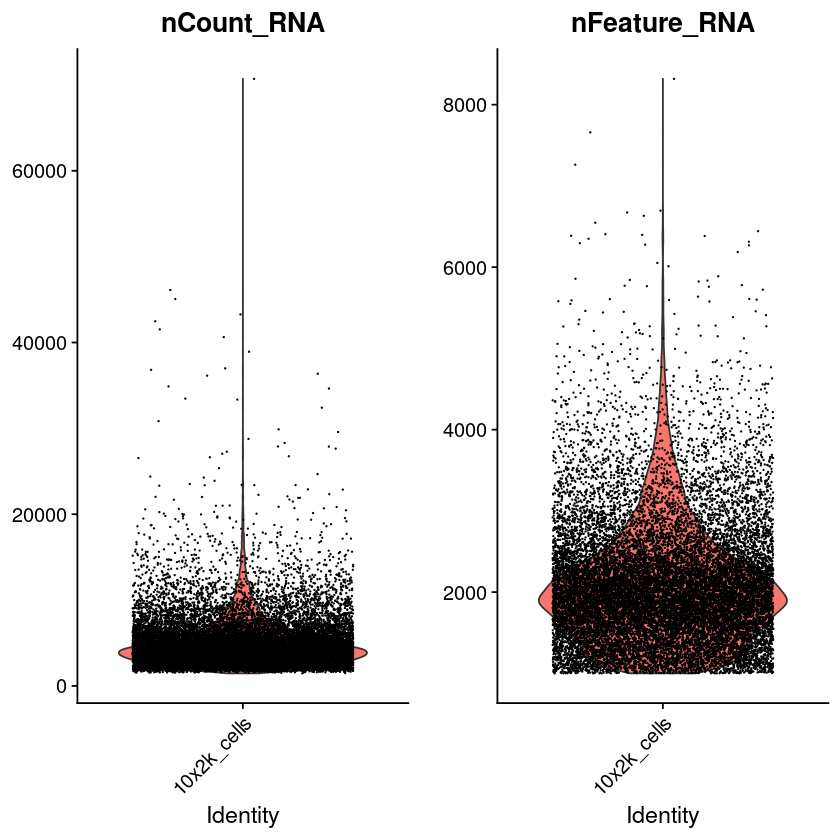

In [21]:
VlnPlot(object = dataset, features = c("nCount_RNA", "nFeature_RNA"),
				pt.size = .01)

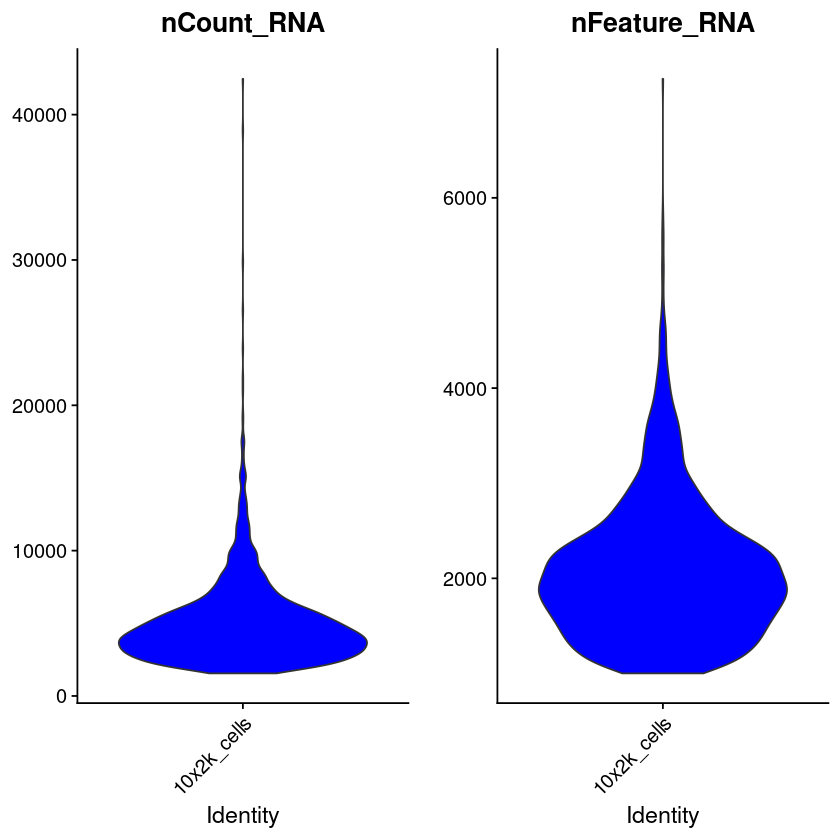

In [13]:
# Just too many dots... Look for transparency
VlnPlot(object = dataset, features = c("nCount_RNA", "nFeature_RNA"),
				pt.size = 0, cols = "blue")

In [14]:
# And here are some numbers
median(dataset@meta.data$nCount_RNA) # raw data 4327
mean(dataset@meta.data$nCount_RNA) # raw data 5028.048 
max(dataset@meta.data$nCount_RNA) # raw data 70708

4332

5026.9968487395

42462

## Standard pre-processing workflow


In [15]:
# Start by generating  QC metrics additional to the no of genes/features
dataset <- PercentageFeatureSet(dataset,pattern='^mt-', col.name = "percent.mt")
dataset <- PercentageFeatureSet(dataset,pattern='Rp(s|l)', col.name = "percent.ribo")

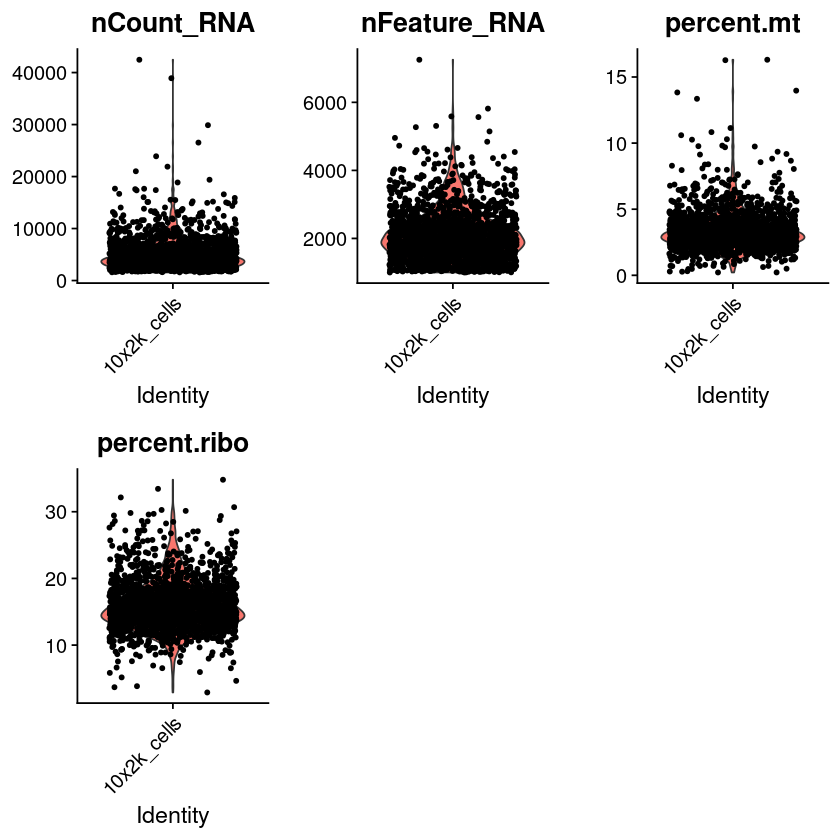

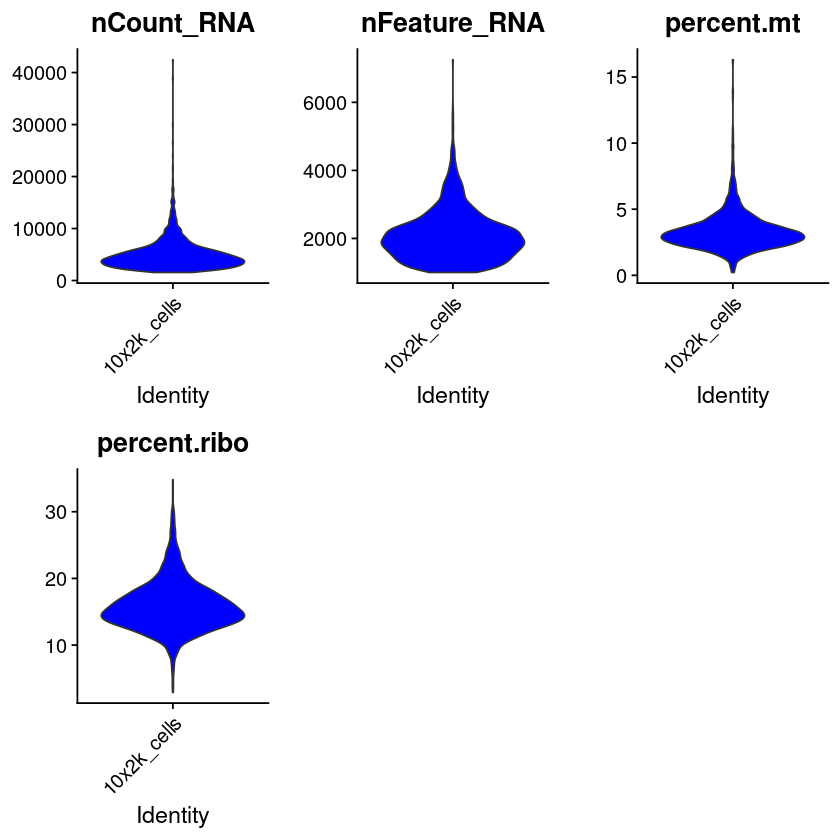

In [16]:
VlnPlot(object = dataset, features = c("nCount_RNA", "nFeature_RNA","percent.mt", "percent.ribo"))
VlnPlot(object = dataset, features = c("nCount_RNA", "nFeature_RNA","percent.mt", "percent.ribo"),pt.size = 0, cols = "blue")


In [17]:
# Now save them all as a pdf file
pdf(paste0(name,"Vlnplot_stats_all.pdf"))
VlnPlot(object = dataset, features = c("nCount_RNA", "nFeature_RNA","percent.mt", "percent.ribo"))
VlnPlot(object = dataset, features = c("nCount_RNA", "nFeature_RNA","percent.mt", "percent.ribo"),pt.size = 0, cols = "blue")
dev.off()


png: 2

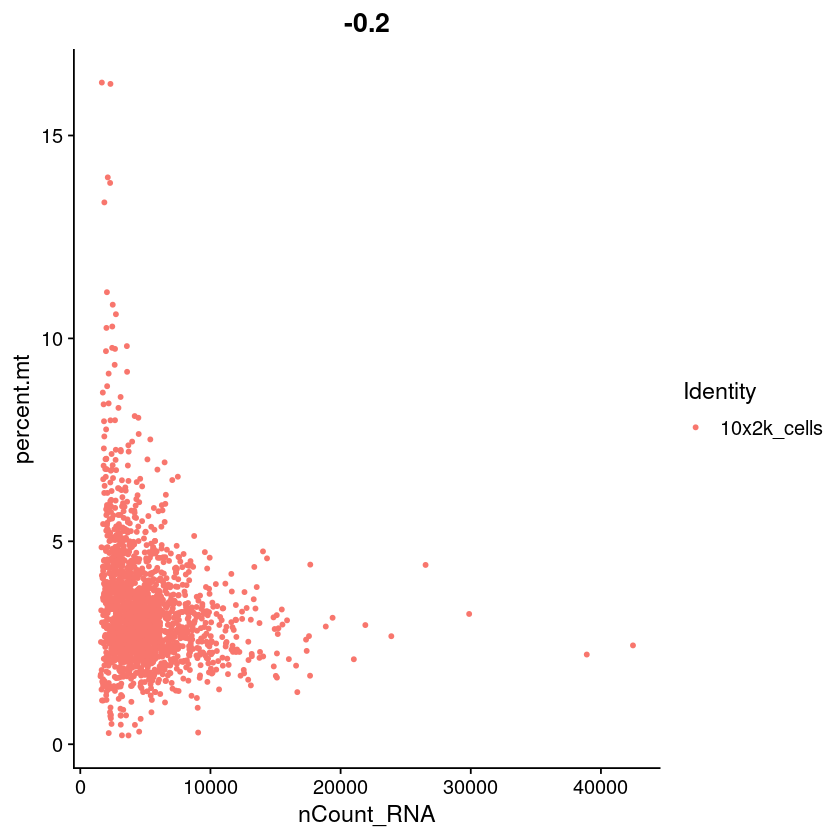

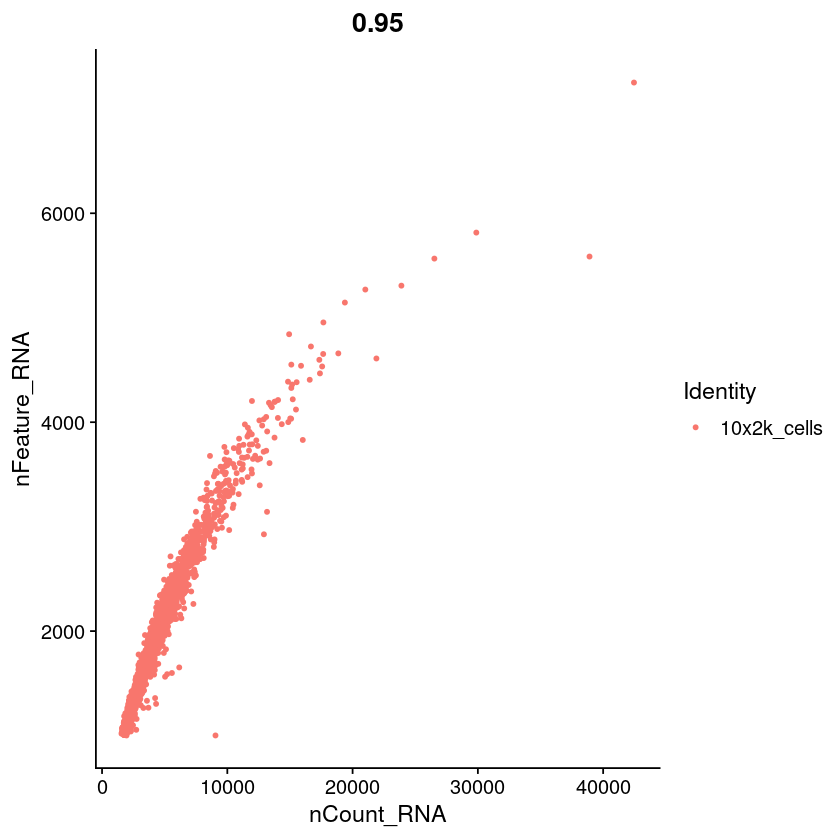

In [18]:
#Let's visualise multiple metrics for each cell 
plot1 <- FeatureScatter(dataset, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot1
plot2 <- FeatureScatter(dataset, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot2
# CombinePlots(plots = list(plot1, plot2))


##### Filter, normalize and find variable features


In [19]:
#Now filter
dataset <- subset(x = dataset, subset = percent.mt < 15 & nCount_RNA < 40000)

In [20]:
# Now let's get rid of the mitochondrial genes which we do not need for downstream analysisb
dataset <- subset(x = dataset[-grep(pattern = "^mt-", x = rownames(dataset), value = FALSE)])
dataset # from 27691 features to 18531 features


An object of class Seurat 
15469 features across 1901 samples within 1 assay 
Active assay: RNA (15469 features)

# GROUP DISCUSSION 1
How do the steps we have taken so far e.g. subsetting, filtering for the number of genes, RNA species and the mitochondrial genes affect ..etcthe results?
1) Spend 2 min thinking by yourself on one major advantage and disadvantage
2) Find a partner and discuss these points, agree on one + and one -
3) share it with others

##### Standard flow is replaced by a single command. However, it is good to see this part to learn each step

In [21]:
## normalise
dataset <- NormalizeData(object = dataset, normalization.method = "LogNormalize", scale.factor = 10000)

In [22]:
## Detection of variable genes across the single cells
## Here, we select the top 1,000 highly variable genes (Hvg) for downstream analysis.
dataset <- FindVariableFeatures(object = dataset, selection.method = 'mean.var.plot', mean.cutoff = c(0.0125, 3), dispersion.cutoff = c(0.5, Inf))
length(x = VariableFeatures(object = dataset)) #3084
## Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(dataset), 10)

1744

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."

When using repel, set xnudge and ynudge to 0 for optimal results


Warning message:
"Removed 1 rows containing missing values (geom_point)."

Warning message:
"Removed 1 rows containing missing values (geom_point)."

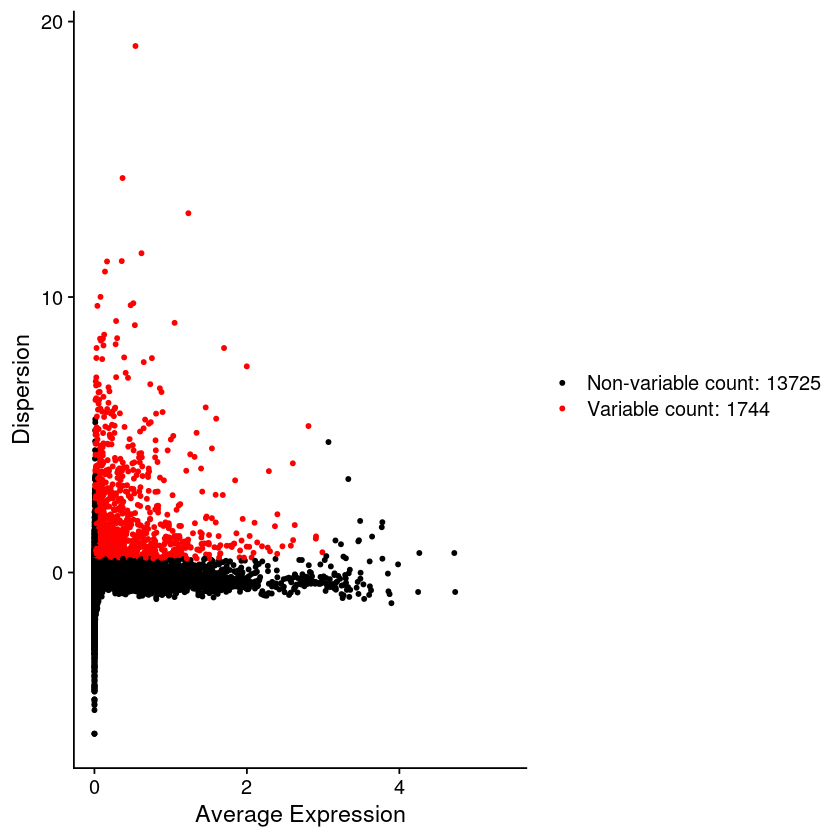

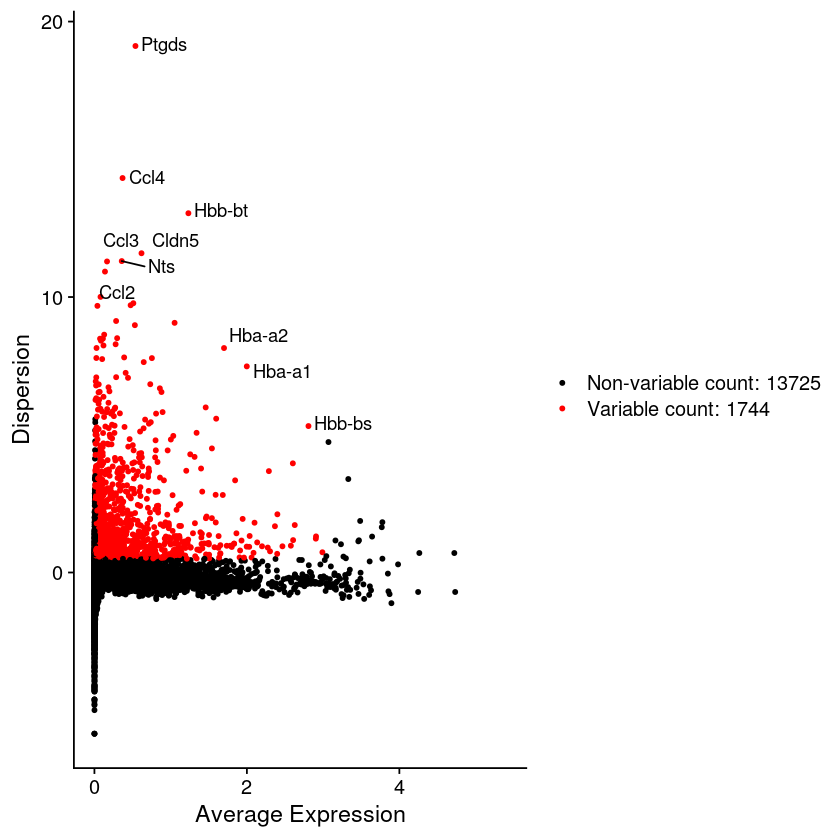

In [23]:
## Plot
# plot variable features with and without labels
plot1 <- VariableFeaturePlot(dataset)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1
plot2
# CombinePlots(plots = list(plot1, plot2))

In [24]:
# Now take the top 1000
hv.genes <- head(rownames(HVFInfo(object = dataset)), 1000)
hv.genes


'Xkr4' 
 'Rp1' 
 'Sox17' 
 'Mrpl15' 
 'Lypla1' 
 'Tcea1' 
 'Rgs20' 
 'Atp6v1h' 
 'Rb1cc1' 
 '4732440D04Rik' 
 'St18' 
 'Pcmtd1' 
 'Gm26901' 
 'Sntg1' 
 'Rrs1' 
 'Adhfe1' 
 '3110035E14Rik' 
 'Mybl1' 
 'Vcpip1' 
 '1700034P13Rik' 
 'Sgk3' 
 'Mcmdc2' 
 'Snhg6' 
 'Ppp1r42' 
 'Cops5' 
 'Cspp1' 
 'Arfgef1' 
 'Cpa6' 
 'Prex2' 
 'A830018L16Rik' 
 'Sulf1' 
 'Slco5a1' 
 'Ncoa2' 
 'Tram1' 
 'Lactb2' 
 'Eya1' 
 'Msc' 
 'Kcnb2' 
 'Terf1' 
 '4930444P10Rik' 
 'Rpl7' 
 'Rdh10' 
 'Stau2' 
 'Ube2w' 
 'Tceb1' 
 'D030040B21Rik' 
 'Tmem70' 
 'Ly96' 
 'Jph1' 
 'Gdap1' 
 'Crispld1' 
 'Gm15825' 
 'Tfap2d' 
 'Mcm3' 
 '6720483E21Rik' 
 'Paqr8' 
 'Efhc1' 
 'Tram2' 
 'Tmem14a' 
 'Kcnq5' 
 'Rims1' 
 'Gm29107' 
 'Ogfrl1' 
 'Gm28822' 
 'B3gat2' 
 'Smap1' 
 'Sdhaf4' 
 'Fam135a' 
 'Col9a1' 
 'Col19a1' 
 'Lmbrd1' 
 'Adgrb3' 
 'Phf3' 
 'Ptp4a1' 
 'Khdrbs2' 
 'Gm5415' 
 'Gm37724' 
 'Prim2' 
 'Rab23' 
 'Bag2' 
 'Zfp451' 
 'Bend6' 
 'Dst' 
 'Gm37233' 
 'Ccdc115' 
 'Imp4' 
 'Ptpn18' 
 'Amer3' 
 'Arhgef4' 
 'Gm38336' 
 'Fam168b' 
 'Plekhb2' 
 'Hs6st1' 
 'Uggt1' 
 'Neurl3' 
 'Arid5a' 
 '4930403P22Rik' 
 'Kansl3' 
 'Lman2l' 
 'Cnnm4' 
 'Cnnm3' 
 'Ankrd23' 
 'Ankrd39' 
 'Sema4c' 
 'Cox5b' 
 'Actr1b' 
 '4933424G06Rik' 
 'Zap70' 
 'Tmem131' 
 'Vwa3b' 
 'Gm37020' 
 'Inpp4a' 
 'Coa5' 
 'Unc50' 
 'Mgat4a' 
 '2010300C02Rik' 
 'Tsga10' 
 'Lipt1' 
 'Mitd1' 
 'Mrpl30' 
 'Txndc9' 
 'Eif5b' 
 'Rev1' 
 'Aff3' 
 'Gm16152' 
 'Lonrf2' 
 'Chst10' 
 'Pdcl3' 
 'Rpl31' 
 'Tbc1d8' 
 'Cnot11' 
 'Rnf149' 
 'Creg2' 
 '1700066B17Rik' 
 'Map4k4' 
 'Gm16894' 
 'Il1r1' 
 'Il1rl2' 
 'Mfsd9' 
 'Gm28634' 
 'Gm29260' 
 'Gm9915' 
 'Gm28175' 
 'Pantr1' 
 'Pou3f3' 
 'Mrps9' 
 'Gpr45' 
 'Tgfbrap1' 
 '8430432A02Rik' 
 'AI597479' 
 'Fhl2' 
 'Nck2' 
 '1500015O10Rik' 
 'Gm29157' 
 'Uxs1' 
 'Tpp2' 
 'Mettl21c' 
 'Gm8251' 
 'Tex30' 
 'Kdelc1' 
 'Bivm' 
 'Ercc5' 
 'Gulp1' 
 'Col3a1' 
 'Col5a2' 
 'Wdr75' 
 'Slc40a1' 
 'Dnah7b' 
 'Slc39a10' 
 'Gm28151' 
 'Tmeff2' 
 'Sdpr' 
 'Nabp1' 
 'Myo1b' 
 'Stat1' 
 'Gls' 
 'Nab1' 
 'Tmem194b' 
 'Mfsd6' 
 'Inpp1' 
 'Hibch' 
 '1700019D03Rik' 
 'Pms1' 
 'Ormdl1' 
 'Osgepl1' 
 'Gm28551' 
 'Asnsd1' 
 'Dnah7a' 
 'Stk17b' 
 'Hecw2' 
 'Gtf3c3' 
 'Pgap1' 
 'Ankrd44' 
 'Sf3b1' 
 'Coq10b' 
 'Hspd1' 
 'Hspe1' 
 'Mob4' 
 'Rftn2' 
 'Gm10561' 
 'Mars2' 
 'Plcl1' 
 '9130227L01Rik' 
 'Satb2' 
 '4930558J18Rik' 
 '1700066M21Rik' 
 'Tyw5' 
 '9430016H08Rik' 
 'Spats2l' 
 'Kctd18' 
 'Sgol2a' 
 'Aox4' 
 'Bzw1' 
 'Clk1' 
 'Ppil3' 
 'Nif3l1' 
 'Orc2' 
 'Gm15834' 
 'Fam126b' 
 'Ndufb3' 
 'Cflar' 
 'Casp8' 
 'Trak2' 
 'Stradb' 
 'Tmem237' 
 'G730003C15Rik' 
 'Als2' 
 'Fzd7' 
 'Gm973' 
 'Sumo1' 
 'Nop58' 
 'Bmpr2' 
 'Fam117b' 
 'Ica1l' 
 'Wdr12' 
 'Carf' 
 'Nbeal1' 
 'Cyp20a1' 
 'Abi2' 
 'Raph1' 
 '9530026F06Rik' 
 'Pard3b' 
 'Nrp2' 
 'Ino80d' 
 'Ino80dos' 
 'Gm20342' 
 'Ndufs1' 
 'Eef1b2' 
 'Zdbf2' 
 'Adam23' 
 'Fastkd2' 
 'Klf7' 
 'Creb1' 
 'Mettl21a' 
 'Ccnyl1' 
 'Fzd5' 
 'Plekhm3' 
 'Crygb' 
 'D630023F18Rik' 
 'Idh1' 
 'Pikfyve' 
 'Pth2r' 
 'Map2' 
 'Gm10558' 
 'Unc80' 
 'Rpe' 
 'Kansl1l' 
 'Acadl' 
 'Lancl1' 
 'Cps1' 
 'Erbb4' 
 'Ikzf2' 
 'Spag16' 
 'Bard1' 
 'Atic' 
 'Fn1' 
 'Apol7d' 
 'Mreg' 
 'D230017M19Rik' 
 'Pecr' 
 'Tmem169' 
 'Xrcc5' 
 'March4' 
 'Smarcal1' 
 'Rpl37a' 
 'Igfbp2' 
 'Igfbp5' 
 '6030407O03Rik' 
 'Tns1' 
 'Arpc2' 
 'Aamp' 
 'Pnkd' 
 'Tmbim1' 
 'Slc11a1' 
 'Ctdsp1' 
 'Usp37' 
 'Rqcd1' 
 'Plcd4' 
 'Zfp142' 
 'Bcs1l' 
 'Rnf25' 
 'Stk36' 
 'Ttll4' 
 'Wnt6' 
 'Wnt10a' 
 'Cdk5r2' 
 'Ihh' 
 'Nhej1' 
 'Cnppd1' 
 'Fam134a' 
 'Zfand2b' 
 'Abcb6' 
 'Atg9a' 
 'Ankzf1' 
 'Glb1l' 
 'Stk16' 
 'Tuba4a' 
 'Dnajb2' 
 'Ptprn' 
 'Resp18' 
 'Dnpep' 
 'Des' 
 'Speg' 
 'Gmppa' 
 'Asic4' 
 'Chpf' 
 'Obsl1' 
 'Tmem198' 
 'Inha' 
 'Stk11ip' 
 'Slc4a3' 
 'Gm29069' 
 'Epha4' 
 'Gm28386' 
 'Farsb' 
 'Acsl3' 
 'Utp14b' 
 'Kcne4' 
 'Scg2' 
 'Wdfy1' 
 'Mrpl44' 
 'Serpine2' 
 'Fam124b' 
 'Cul3' 
 'Dock10' 
 'Nyap2' 
 'Irs1' 
 'Rhbdd1' 
 'Col4a4' 
 'Col4a3' 
 'Mff' 
 'Agfg1' 
 'Slc19a3' 
 'Ccl20' 
 'Sphkap' 
 'Pid1' 
 'Dner' 
 'Trip12' 
 'Fbxo36' 
 'Slc16a14' 
 'Sp110' 
 'Sp140' 
 'Sp100' 
 'A630001G21Rik' 
 '

In [0]:
#This is the new function replacing the lines above
#library(sctransform)
#dataset <- SCTransform(dataset, vars.to.regress = "percent.mt", verbose = FALSE)


In [25]:
dataset <- ScaleData(object = dataset, features = hv.genes, vars.to.regress = "percent.mt" ) #features = rownames(x = mca),

Regressing out percent.mt


Centering and scaling data matrix


### Dimention reduction techniques

In [26]:
# Dimention reduction
dataset <- RunPCA(object = dataset, features = hv.genes, verbose = FALSE)
dataset <- RunUMAP(object = dataset, reduction = "pca", dims = 1:20)
dataset <- RunTSNE(object = dataset, dims = 1:10)


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"

11:47:21 UMAP embedding parameters a = 0.9922 b = 1.112


11:47:21 Read 1901 rows and found 20 numeric columns


11:47:21 Using Annoy for neighbor search, n_neighbors = 30


11:47:21 Building Annoy index with metric = cosine, n_trees = 50


0%   10   20   30   40   50   60   70   80   90   100%


[----|----|----|----|----|----|----|----|----|----|


*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

|


11:47:22 Writing NN index file to temp file /tmp/RtmpqtZGRa/file1a696764f984e


11:47:22 Searching Annoy index using 1 thread, search_k = 3000


11:47:23 Annoy recall = 100%


11:47:23 Commencing smooth kNN distance calibration using 1 thread


11:47:24 Initializing from normalized Laplacian + noise


11:47:24 Commencing optimization for 500 epochs, with 74416 positive edges


11:47:28 Optimization finished


#### Examine and visualize PCA results a few different ways

In [27]:
print(dataset[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  Ptma, Celf2, H3f3a, Cntn2, Frmd4a 
Negative:  Vim, Dbi, Atp1a2, Tagln2, Pea15a 
PC_ 2 
Positive:  Cntn2, Nrp2, Klf7, Mndal, Zbtb18 
Negative:  Pantr1, Cenpf, Nuf2, Sgol2a, Ptma 
PC_ 3 
Positive:  Epha4, Cenpf, Aspm, Nuf2, Sgol2a 
Negative:  Cd34, F11r, Slc40a1, Rcsd1, Atf3 
PC_ 4 
Positive:  2810459M11Rik, Igfbp5, Dbi, 1500015O10Rik, Pea15a 
Negative:  Cenpf, Sgol2a, Nuf2, Ptma, Nek2 
PC_ 5 
Positive:  Pantr1, Pou3f3, Satb2, Frmd4a, Gm29260 
Negative:  Spats2l, Lhx9, Prox1, Mndal, Ramp1 


#### visualise the contributions of genes to variation

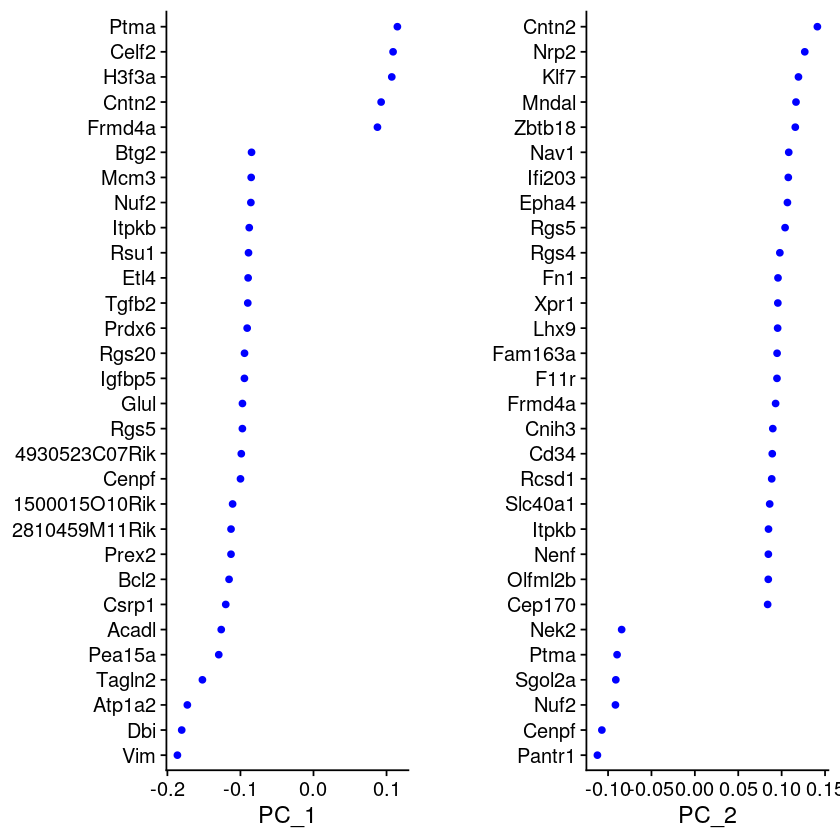

In [28]:
VizDimLoadings(dataset, dims = 1:2, reduction = "pca")

#### Determine statistically significant principal components

Warning message:
"Removed 11233 rows containing missing values (geom_point)."

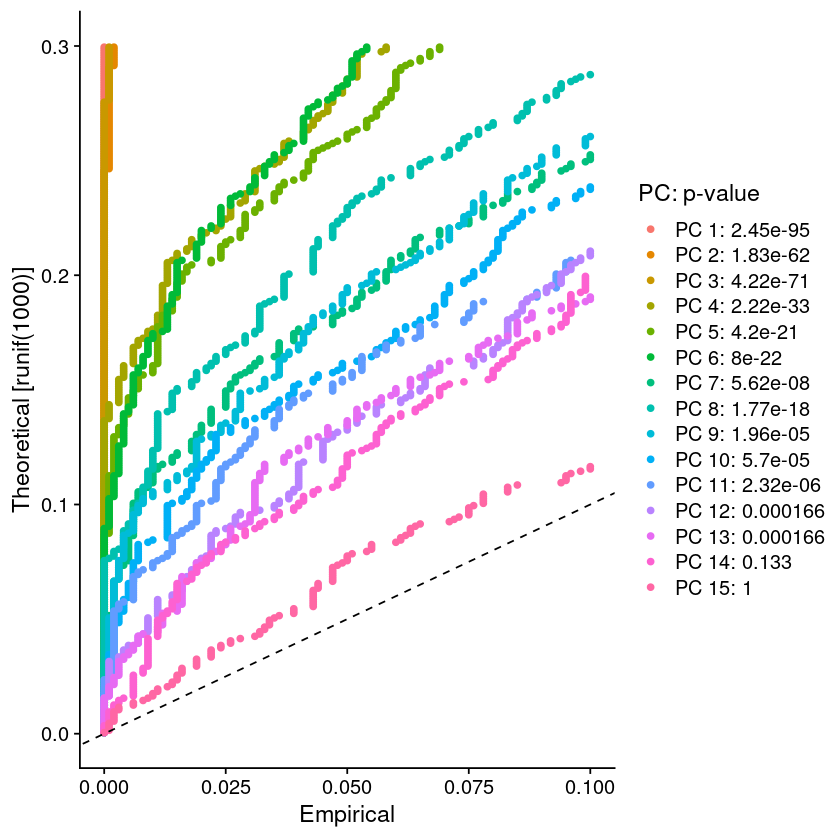

In [29]:
dataset <- JackStraw(object = dataset, num.replicate = 100)
dataset <- ScoreJackStraw(object = dataset, dims = 1:20)
JackStrawPlot(object = dataset, dims = 1:15)


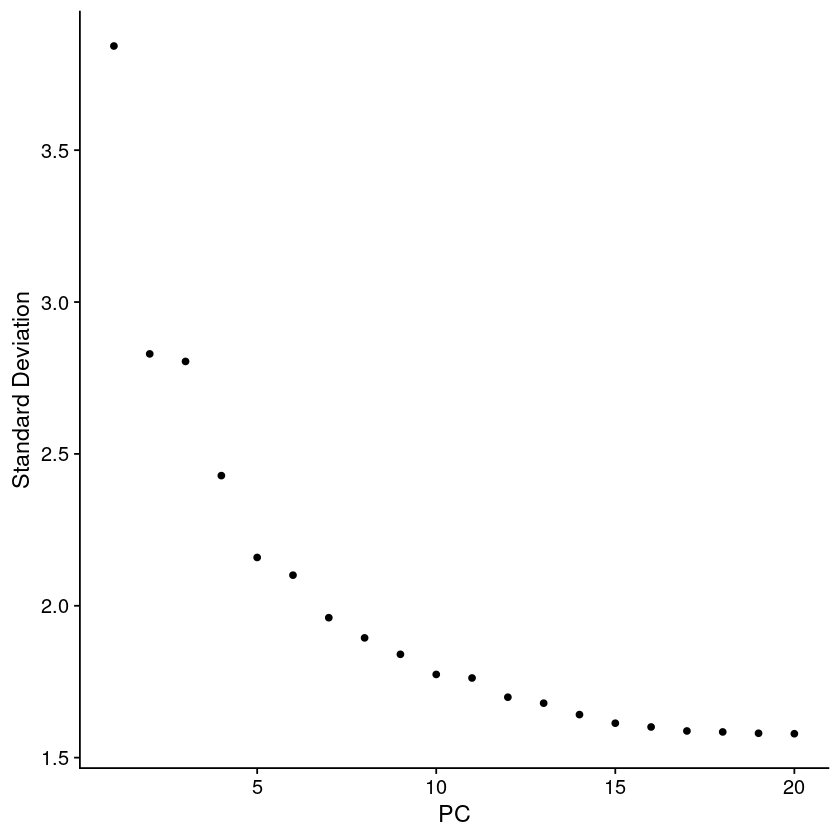

In [30]:
# Plots the standard deviations (or approximate singular values if running PCAFast) of the principle components for easy identification of an elbow in the graph. This elbow often corresponds well with the significant dims and speeds up running than Jackstraw
# In this example, it looks like the elbow would fall around PC 11, even though at around 5 is the first elbow.
ElbowPlot(object = dataset, reduction = "pca")

# QUESTION 1
Some genes contribute more to the variation then others... What do these genes and principle components tell us?
How would our results change if we include less or more pinciple components for downstream analysis?

### Find clusters

In [31]:
dataset <- FindNeighbors(object = dataset, dims = 1:14)
dataset <- FindClusters(object = dataset, resolution = 0.6)# c(0.6, 0.8, 1)

Computing nearest neighbor graph


Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1901
Number of edges: 70932

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7789
Number of communities: 8
Elapsed time: 0 seconds


### find marker genes for each cluster

#### Start with a single cluster

In [32]:
cluster1.markers <- FindMarkers(object = dataset, ident.1 = 1, min.pct = 0.25) #, ident.2 = c(0, 3) to compare
head(x = cluster1.markers, n = 5)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gad2,1.775117e-118,1.355019,0.530,0.053,2.745929e-114
Dlx6os1,8.294470e-109,1.479686,0.509,0.056,1.283072e-104
Dlx2,6.730831e-107,1.291832,0.537,0.066,1.041192e-102
Nrxn3,7.319892e-107,1.448114,0.561,0.083,1.132314e-102
Maf,1.866959e-95,1.244169,0.369,0.024,2.887998e-91


#### Find markers for every cluster compared to all remaining cells, report only the positive ones

In [47]:
library(dplyr)
dataset.markers <- FindAllMarkers(object = dataset, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
dataset.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_logFC)
# Takes a bit of time


Attaching package: 'dplyr'



The following objects are masked from 'package:stats':

    filter, lag



The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Calculating cluster 0


Calculating cluster 1


Calculating cluster 2


Calculating cluster 3


Calculating cluster 4


Calculating cluster 5


Calculating cluster 6


Calculating cluster 7


p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
2.903661e-160,1.103199,0.951,0.417,4.491673e-156,0,Neurod2
1.134072e-143,1.072500,0.955,0.602,1.754297e-139,0,Gria2
8.294470e-109,1.479686,0.509,0.056,1.283072e-104,1,Dlx6os1
7.319892e-107,1.448114,0.561,0.083,1.132314e-102,1,Nrxn3
2.175493e-115,1.501216,0.650,0.093,3.365270e-111,2,Eomes
3.602504e-30,1.144356,0.471,0.187,5.572714e-26,2,Neurog2
8.734113e-95,1.513387,0.980,0.718,1.351080e-90,3,Zbtb20
1.472732e-71,1.561457,0.649,0.161,2.278169e-67,3,Snca
2.025336e-109,2.541382,1.000,0.586,3.132991e-105,4,Dbi


#### find markers for every cluster compared to all remaining cells, report only the positive ones

In [48]:
library(openxlsx)
## Create Workbook object and add worksheets
wb <- createWorkbook()
## Add the cluster info
for ( n in unique(dataset.markers$cluster) ) {
  addWorksheet(wb, n)
  writeData(wb, n, dataset.markers[dataset.markers$cluster == n,], startCol = 1, startRow = 1, rowNames = TRUE, colNames = TRUE)
}
#save
saveWorkbook(wb, paste(name,"cell_clust_diff_genes.xlsx",sep=""), overwrite = TRUE)

Note: zip::zip() is deprecated, please use zip::zipr() instead


## Visualise

Warning message in FetchData(object = object, vars = features, slot = slot):
"The following requested variables were not found: percent.ERCC"

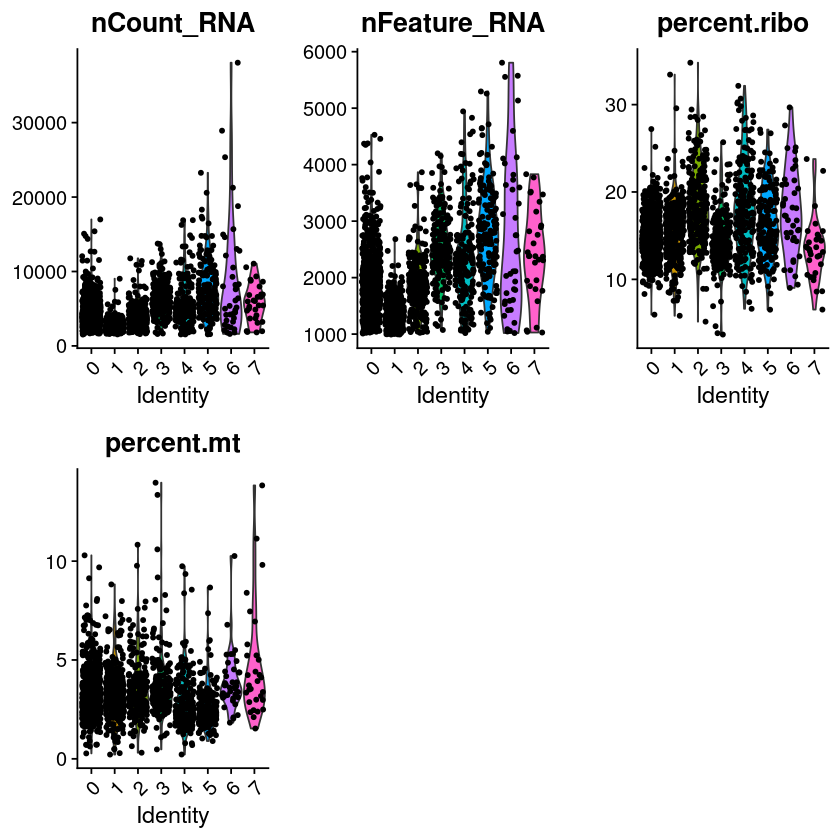

In [35]:
# Statistics
VlnPlot(object = dataset, features = c("nCount_RNA", "nFeature_RNA","percent.ERCC","percent.ribo","percent.mt"))

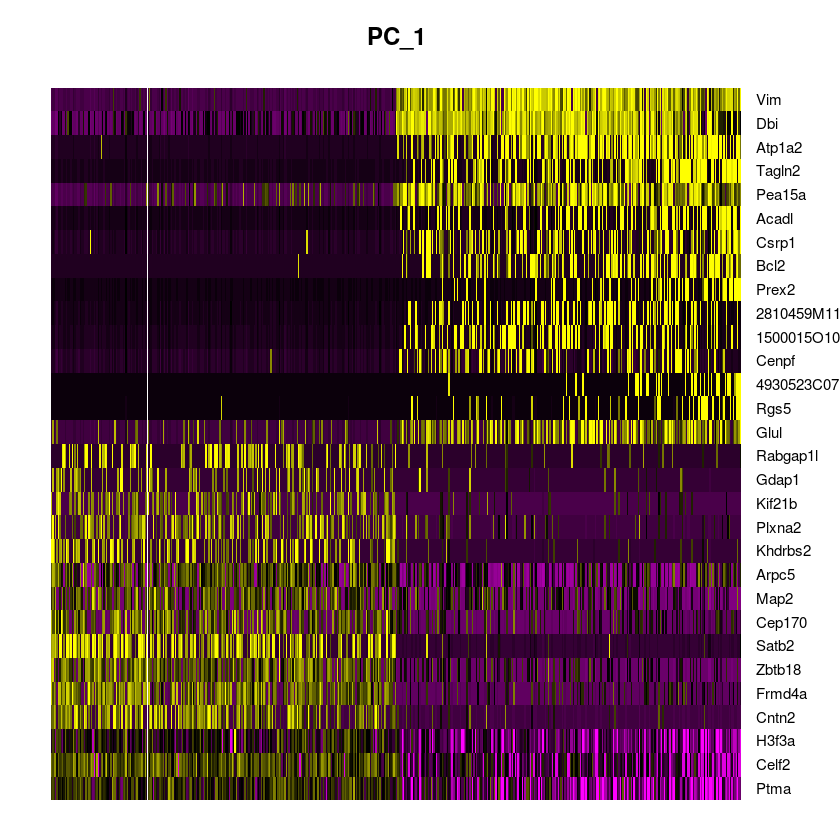

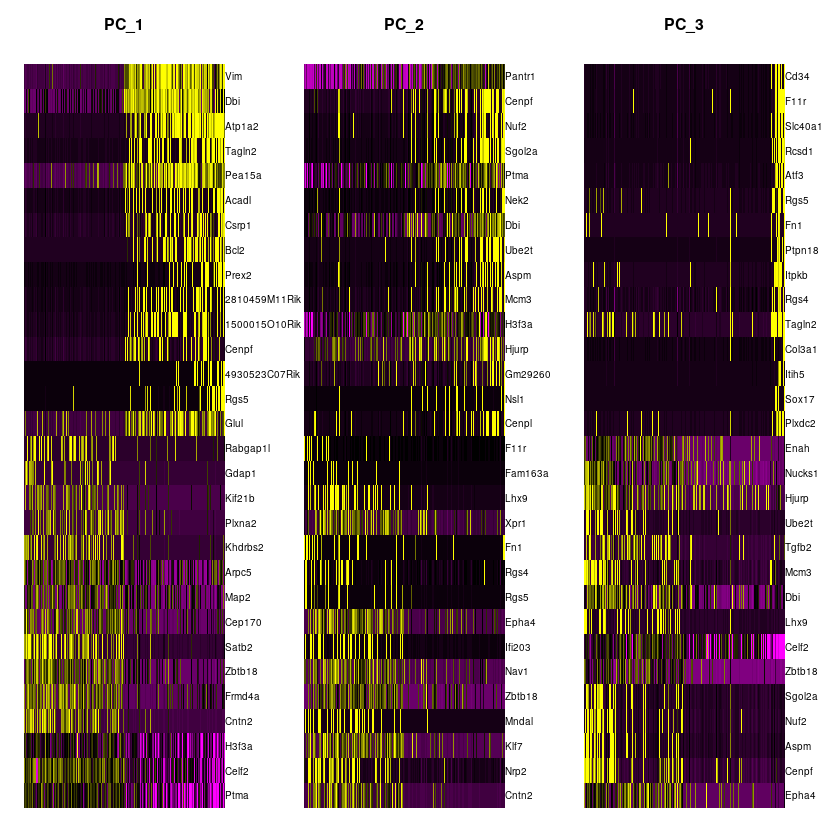

In [36]:
DimHeatmap(dataset, dims = 1, cells = 500, balanced = TRUE)
DimHeatmap(dataset, dims = 1:3, cells = 500, balanced = TRUE)

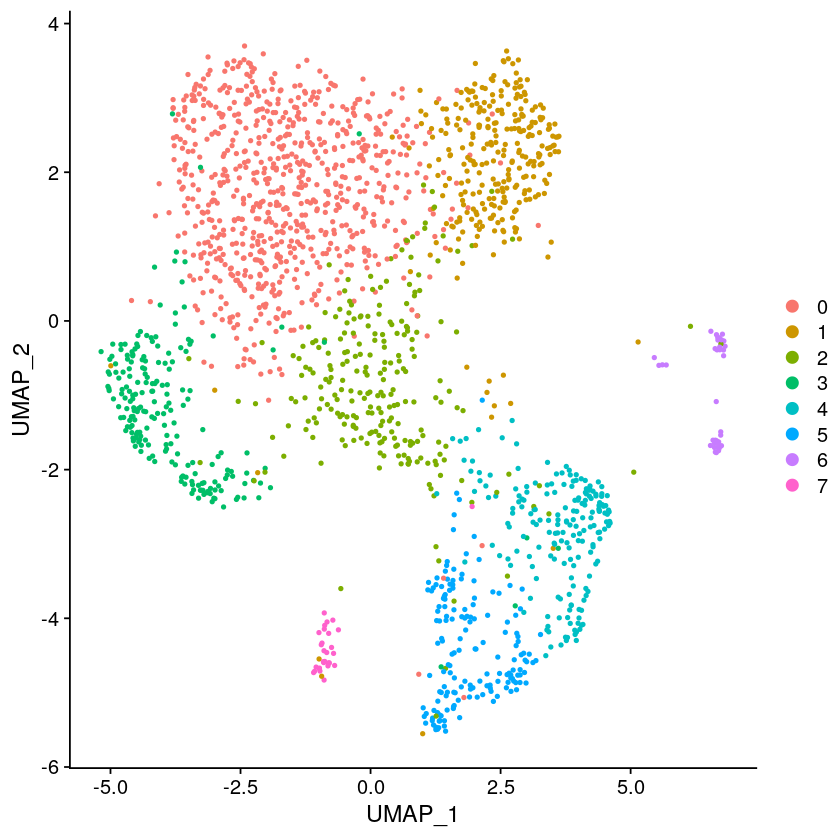

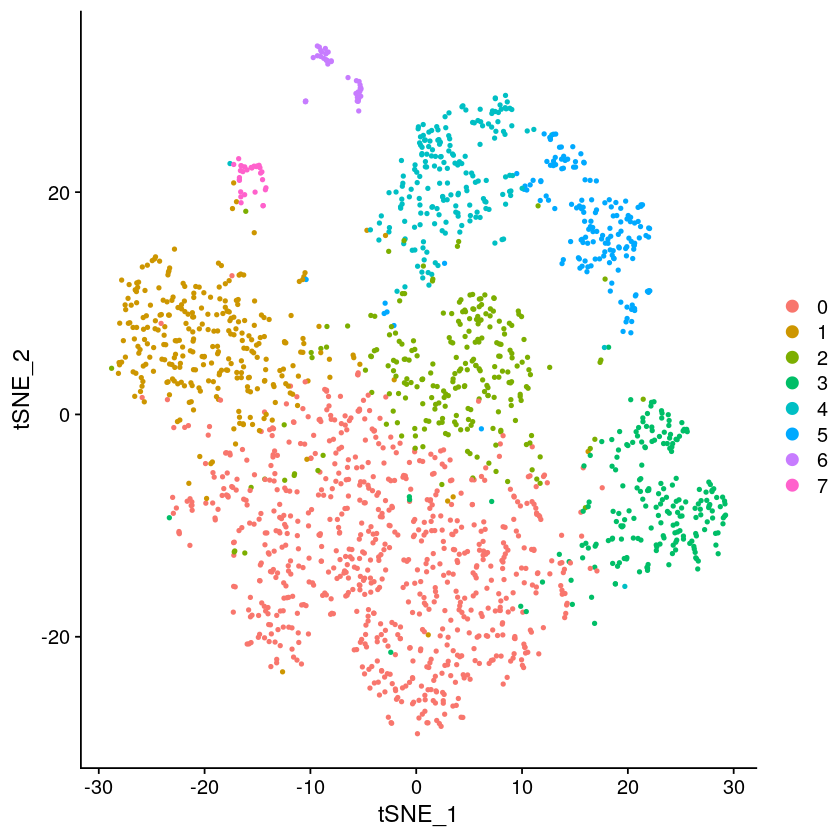

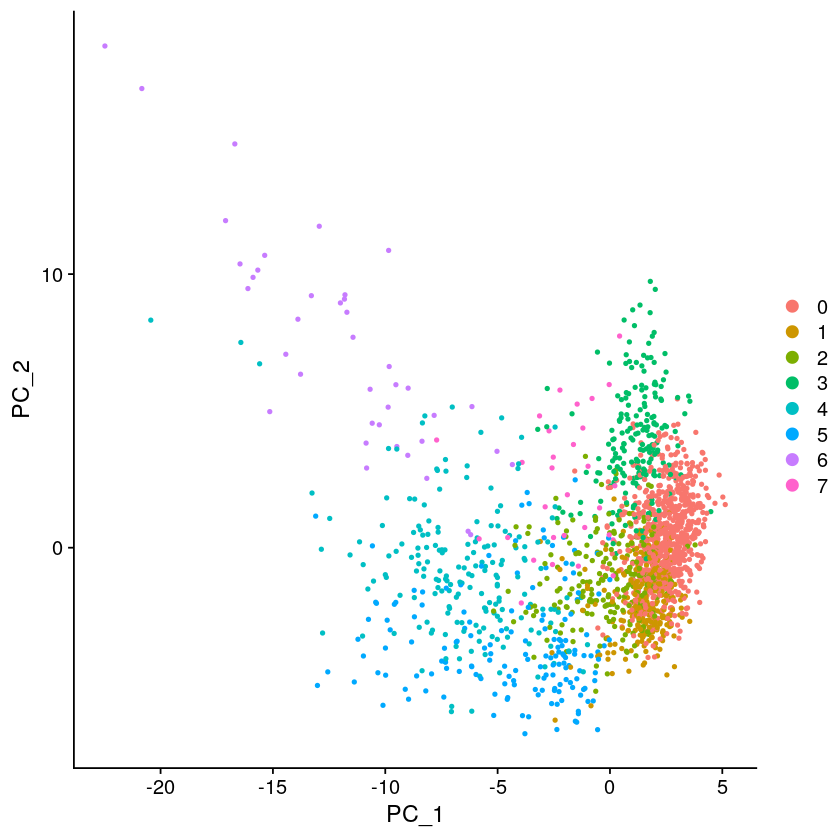

In [37]:
# plot dimentionality reduction results
DimPlot(object = dataset, reduction = 'umap')
DimPlot(object = dataset, reduction = 'tsne')
DimPlot(object = dataset, reduction = 'pca')


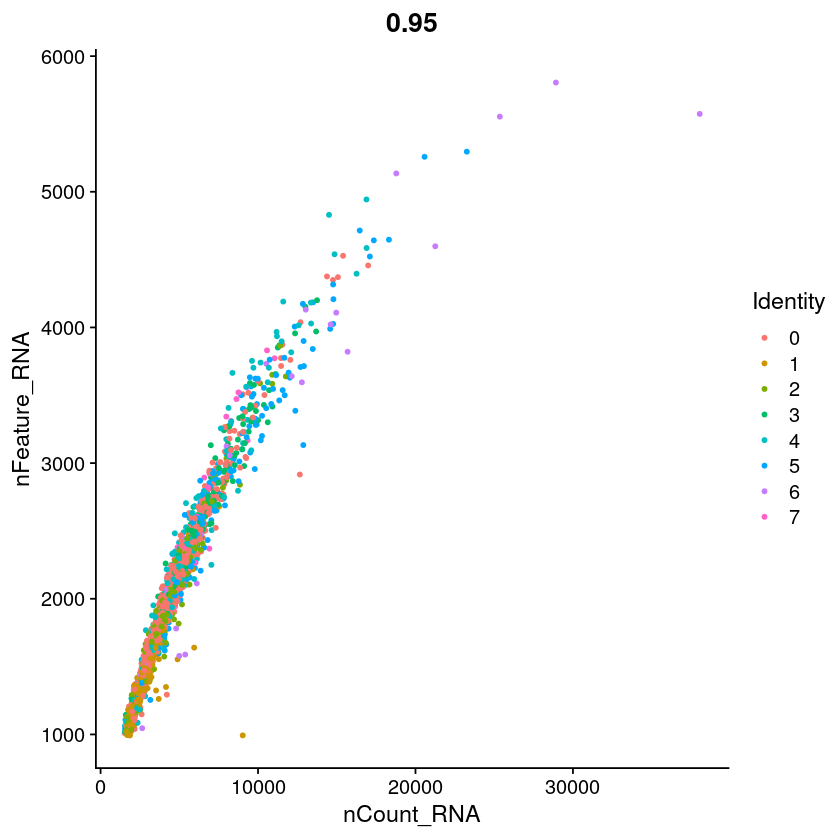

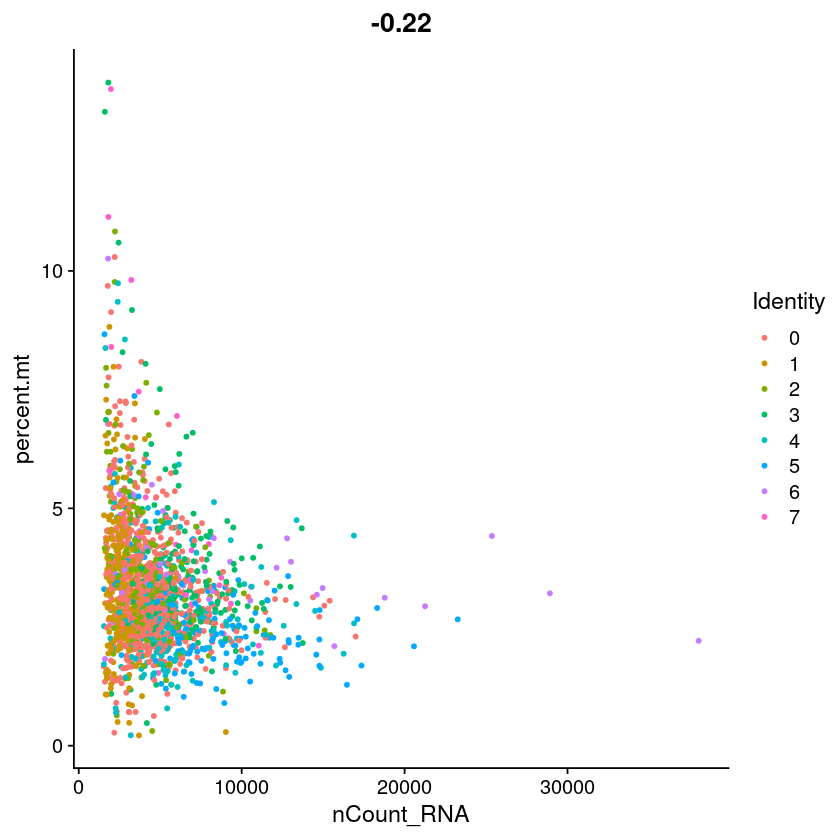

In [41]:
FeatureScatter(object = dataset, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
FeatureScatter(object = dataset, feature1 = "nCount_RNA", feature2 = "percent.mt")

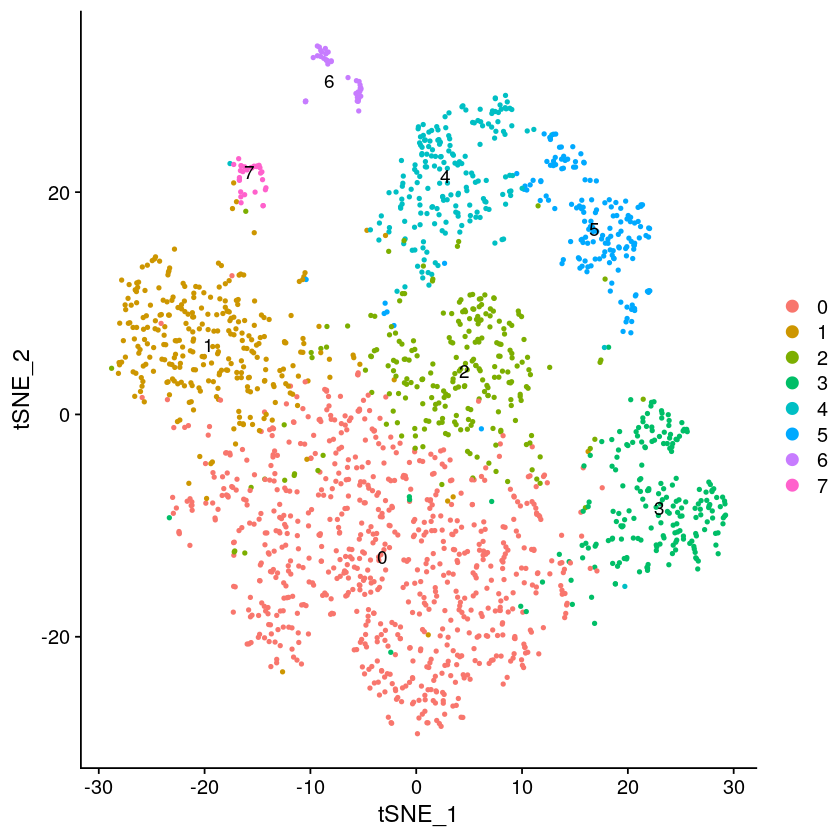

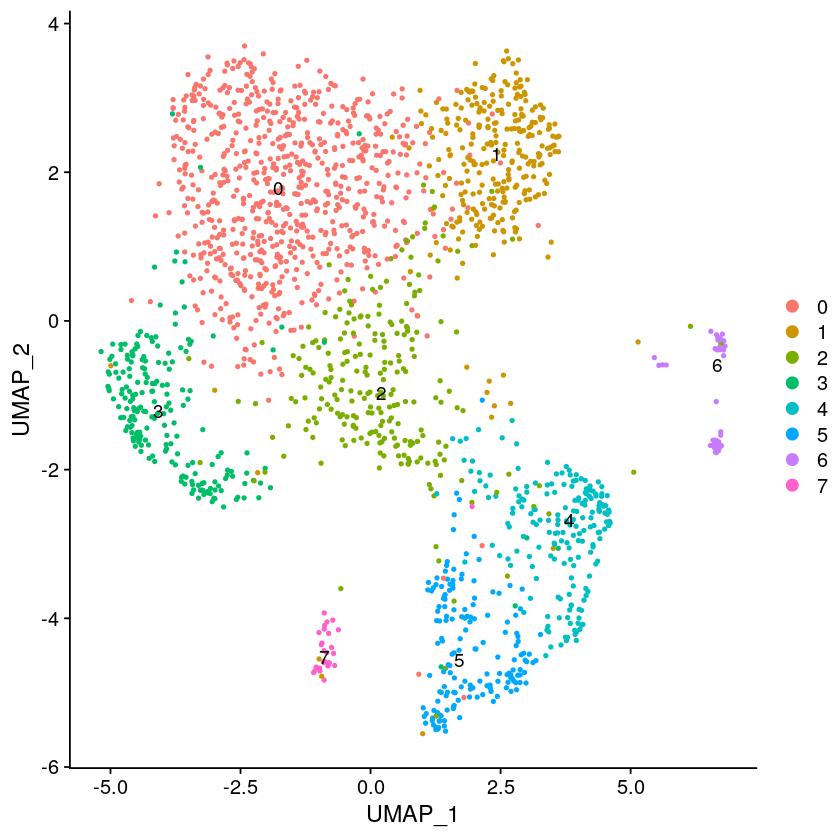

In [42]:
# note that you can set `label = TRUE` or use the LabelClusters function to help label individual clusters
DimPlot(object = dataset, reduction = 'tsne',label = TRUE)
DimPlot(object = dataset, reduction = 'umap',label = TRUE)

#### Visualise genes in clusters using violin plots

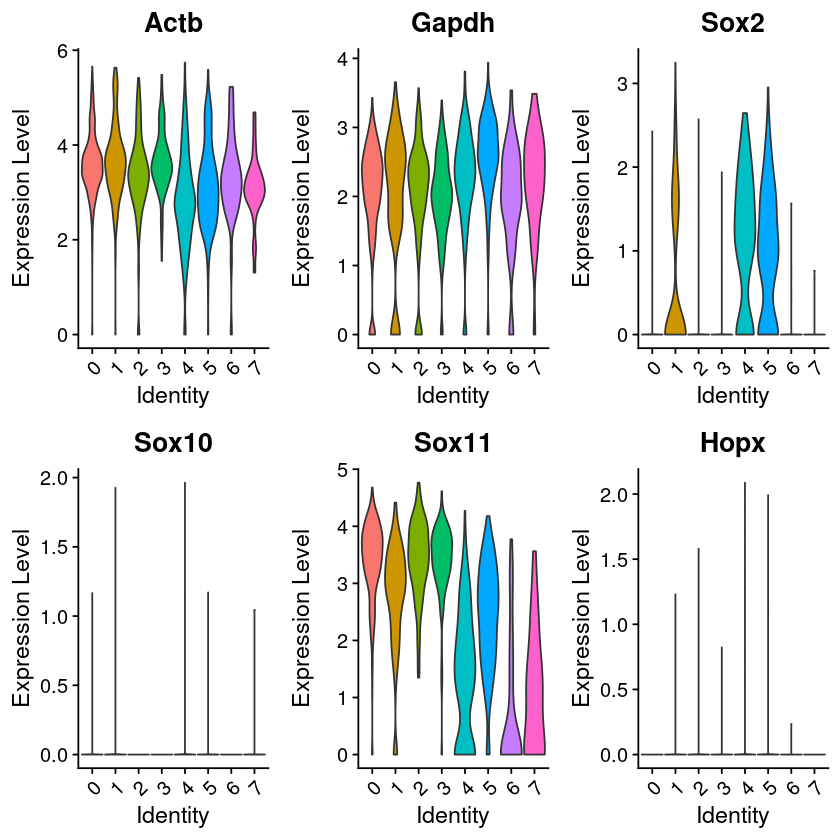

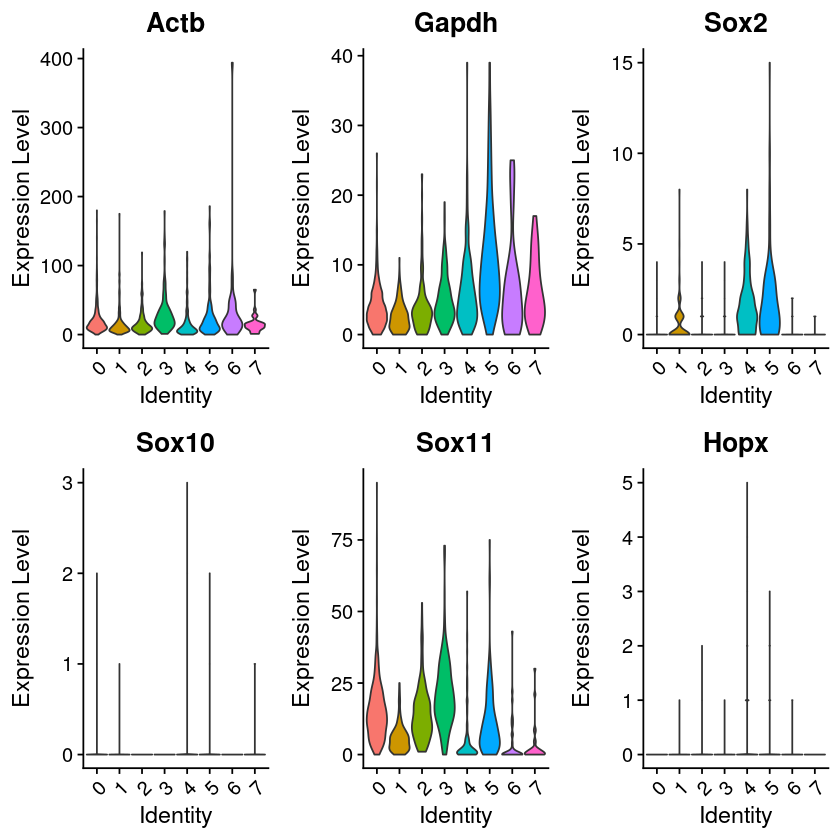

In [43]:
VlnPlot(object = dataset, features = c("Actb","Gapdh","Sox2","Sox10","Sox11","Hopx"),pt.size = 0)
# you can plot raw counts as well
VlnPlot(object = dataset, features = c("Actb","Gapdh","Sox2","Sox10","Sox11","Hopx"), slot = 'counts',pt.size = 0)

#### Let's visualise gene expression on t-SNE plots

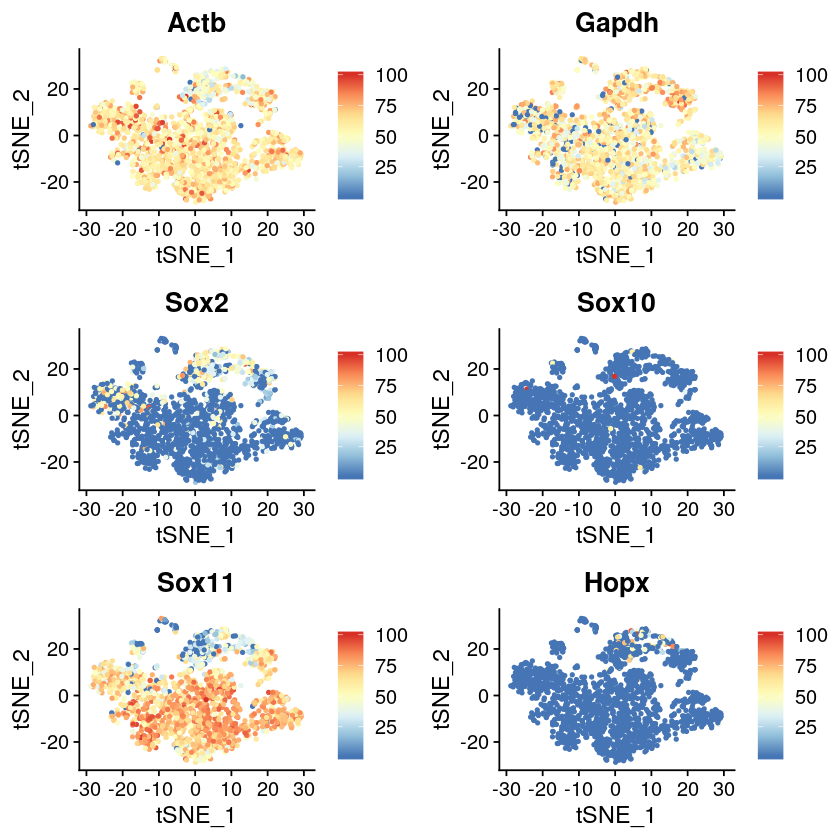

In [44]:
ColorRamp <- colorRampPalette(rev(brewer.pal(n = 7,name = "RdYlBu")))(100) # This is how to generate a color key
FeaturePlot(object = dataset, features = c("Actb","Gapdh","Sox2","Sox10","Sox11","Hopx"),reduction = 'tsne',cols = ColorRamp)

#### DoHeatmap generates an expression heatmap for given cells and features. 
In this case, we are plotting the top 20 markers (or all markers if less than 20) for each cluster.

In [49]:
dataset.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC) -> top10

Warning message in DoHeatmap(object = dataset, features = top10$gene[1:100]):
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: NA, Gap43, Nhlh2, Snhg11, Reln, Cacna2d2, Lhx1os, Ndnf, Bsg, Sparc, Cldn5, Igf2, Higd1b, Vtn, Gng11, Col4a1, Igfbp7, Hmgb2, Cenpa, Rrm2, Ube2c, Cks2, Birc5, Pbk, 2810417H13Rik, Top2a, Id3, Fabp7, Apoe, Slc1a3, Mt3, Mt1, Ddah1, Aldoc, Opcml, Nrxn1, Islr2, Snca, Neurod1, Calb2, Zbtb20, Crym, Neurog2, Pcp4, Sstr2, Ezr, Mfng, Mdk, Mfap4, Eomes, Arx, Nxph1, Sp9, Meg3, Dlx1, Maf, Nrxn3, Dlx2, Dlx6os1, Gad2, Hs6st2, Id2, Gpm6a, Neurod6, Tsc22d1, Cd24a, Gria2, Neurod2"

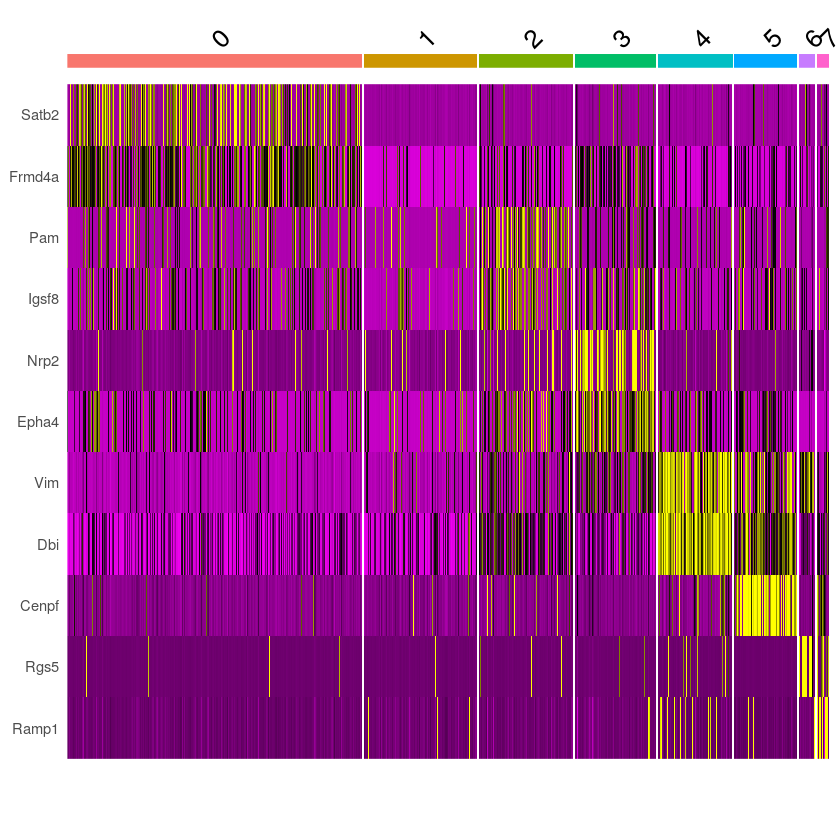

In [50]:
DoHeatmap(object = dataset, features = top10$gene[1:100]) + NoLegend()

## ERROR MESSAGE!!??? 
### QUESTION: What is happening here?

Ridge plots - from ggridges. Visualize single cell expression distributions in each cluster

Regressing out percent.mt


Centering and scaling data matrix


Warning message in DoHeatmap(object = dataset, features = top10$gene[1:100], slot = "scale.data"):
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: NA, Fabp7"

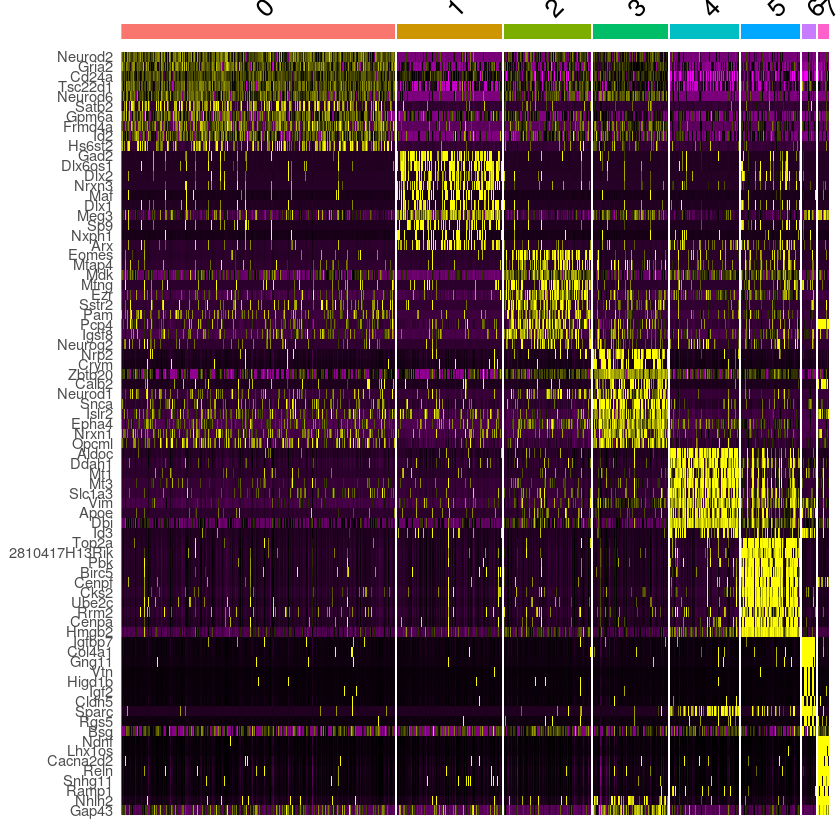

In [52]:
# Answer:
#dataset <- ScaleData(object = dataset, features = rownames(dataset@assays$RNA),vars.to.regress = "percent.mt" ) #features = rownames(x = mca),
dataset <- ScaleData(object = dataset, features = rownames(top10$gene),vars.to.regress = "percent.mt" ) #features = rownames(x = mca),
DoHeatmap(object = dataset, features = top10$gene[1:100],slot =  'scale.data' ) + NoLegend()

Picking joint bandwidth of 0.145


Picking joint bandwidth of 0.0312


Picking joint bandwidth of 0.094


Picking joint bandwidth of 0.178


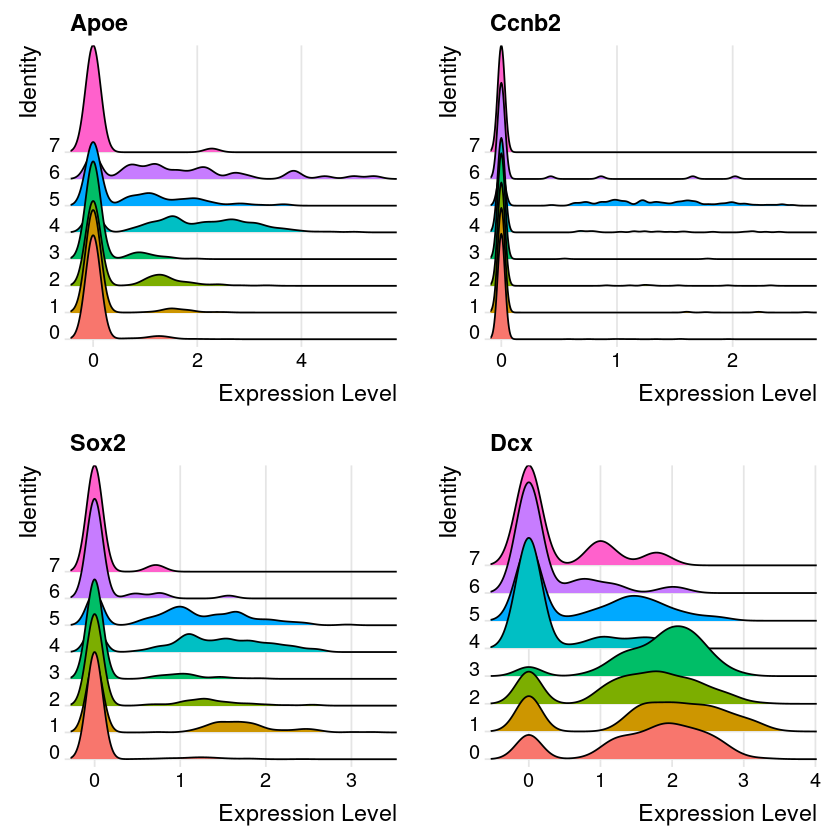

In [51]:
RidgePlot(dataset, features = c("Apoe", "Ccnb2", "Sox2", "Dcx"), ncol = 2)

# Group Assignments
Choose one of the following for your group assignment:

1) Make a 5 min presentation where you explain what you have done and how this affected the results of your analysis.
2) Discuss it with other groups 

Topics:
- How does the number of cells and genes affect our results? Compare multiple sets of 200 to 2k and 20k cells. Try downsampling and taking a small number of reads from each cells
- It is possible to tweak the visualisation plots. Work on the UMAP and tSNE features to i) get more distinct clusters, ii) get more continuous cell streams and ii) try the effect of using different number of principle components for t-SNE. Try plotting different PCs and explain what you see
- Can you determine what cell types are present in a cluster? Use differentially expressed genes and the literature to find out cell types. Perform at least two different differential gene expression test to identify genes upregulated during neuronal differentiation.
- Cell cycle can introduce variability not resulted to cell identity. Can you remove the cell cycle affects and compare the clustering and gene expression change?

More information:
https://satijalab.org/seurat/
https://satijalab.org/seurat/v3.1/visualization_vignette.html
